In [209]:
import pandas as pd
import numpy as np
from shapely.geometry import box, Polygon

In [148]:
import folium
import requests
import json
import plotly.express as px
import pandas as pd

In [62]:
m = folium.Map(location=[40.28, -89.39])

In [389]:
# playing around with folium, this is probably going to replace the google maps call in place on the app currently

url = (
    'https://raw.githubusercontent.com/deldersveld/topojson/master/countries/us-states/IL-17-illinois-counties.json'
)



m = folium.Map(width = 500,
               height = 500,
    location=[40.28, -89.39],
    tiles="cartodbpositron",
    zoom_start=5,
)

folium.Marker(
    location=[36.9815, -91.51135],
    popup='reference',
).add_to(m)

folium.Circle(
    radius=1115,
    location=[40.28, -89.39],
    popup="Chicago",
    color="red",
    fill=True,
    fill_color='red'
).add_to(m)

# folium.GeoJson(url, name="geojson").add_to(m)

folium.TopoJson(
    json.loads(requests.get(url).text),
    "objects.cb_2015_illinois_county_20m",
    name="topojson",
    
).add_to(m)

folium.LayerControl().add_to(m)

m

In [528]:
m.save('m.html')

In [448]:
# summoning and inspecting the topojson data

alpha = json.loads(requests.get(url).text)

In [449]:
# coordinates for reference in understanding above data


# 41.148339, -89.638487
# 36.981528, -91.511353

In [251]:
# inspecting the scale key under the transform key inside of the alpha dictionary

lat_ratio = ((41.148339 - 36.981528)/3344)
long_ratio = ((-89.638487 + 91.511353)/1061)
print(lat_ratio, 'lat ratio')
print(long_ratio, 'long ratio')

0.0012460559210526324 lat ratio
0.0017651894439208312 long ratio


In [424]:
# One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), 
# and one-second equals 101 feet. One-degree of 
# longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), 
# and one second equals 80 feet.

In [512]:
# fitting polygons to shapely Polygon objects

alpha = json.loads(requests.get(url).text)
beta = alpha['arcs']
polys = []
county_names = []

for i, x in enumerate(alpha['objects']['cb_2015_illinois_county_20m']['geometries']):
    poly_shape = []
    for y in x['arcs'][0]:        
        if y<0:
            temp = []
            y = abs(y+1)
            arc_ind = beta[y].copy()
            ref = np.array(arc_ind[0]) 
            temp.append(ref)
            for j in range(1, len(arc_ind)):            
                ref = ref + np.array(arc_ind[j])
                temp.append(ref)
            for zed in reversed(temp):
                poly_shape.append(zed)
        else:
            arc_ind = beta[y].copy()
            ref = np.array(arc_ind[0])
            poly_shape.append(ref)
            for j in range(1, len(arc_ind)):            
                ref = ref + np.array(arc_ind[j])
                poly_shape.append(ref)
    shape_final = Polygon(poly_shape)
    polys.append(shape_final)
    county_names.append(x['properties']['NAME'])

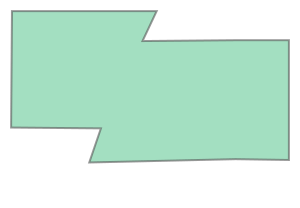

In [514]:
# take a look at marshall county!

polys[0]
# perfect

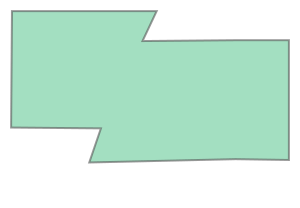

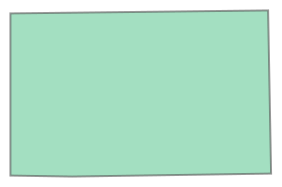

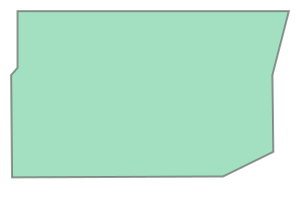

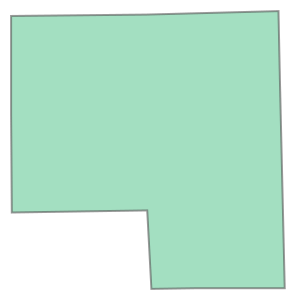

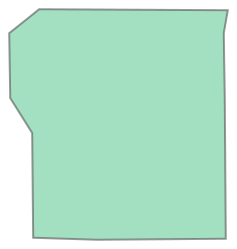

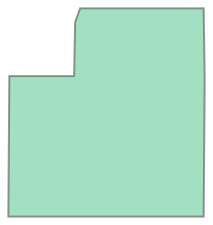

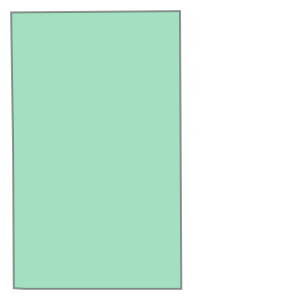

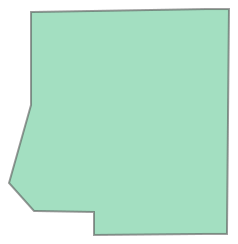

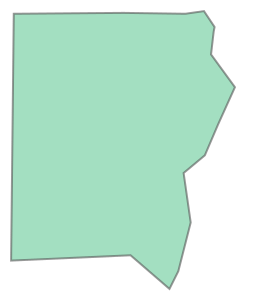

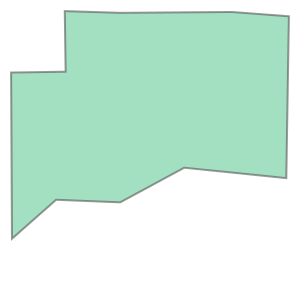

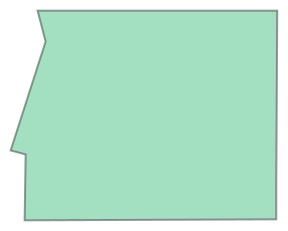

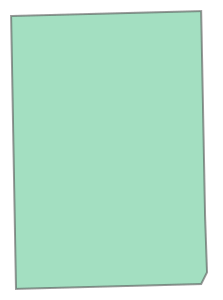

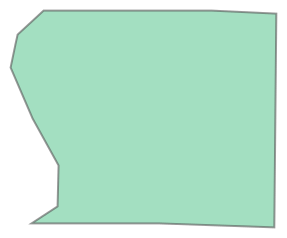

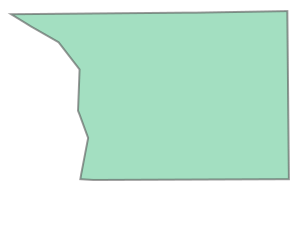

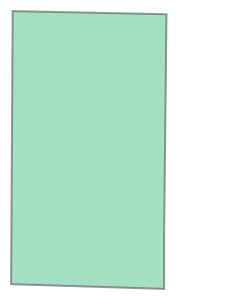

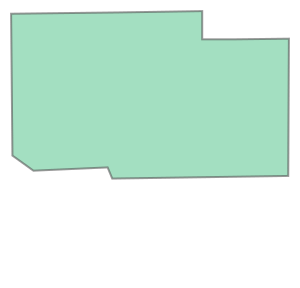

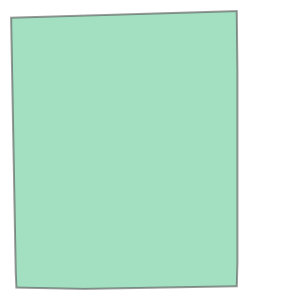

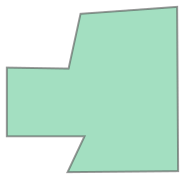

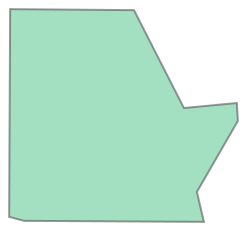

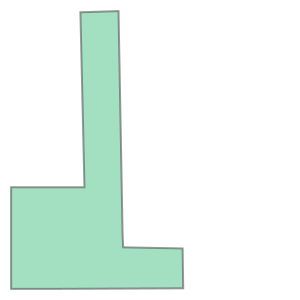

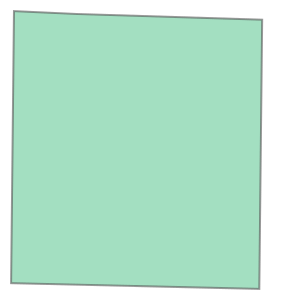

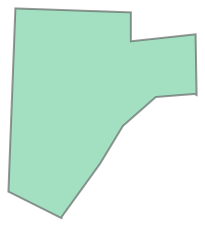

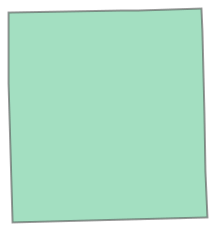

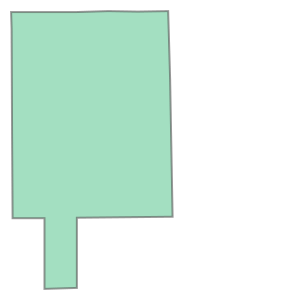

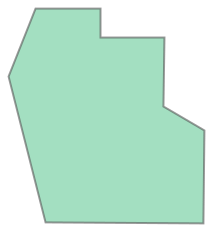

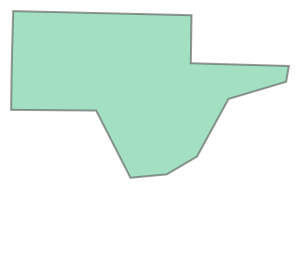

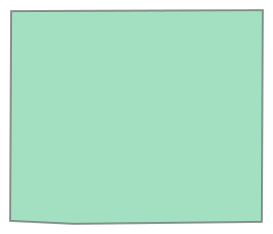

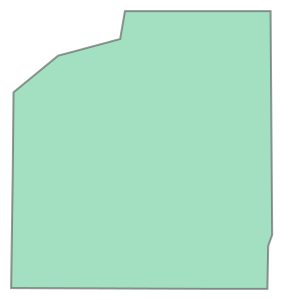

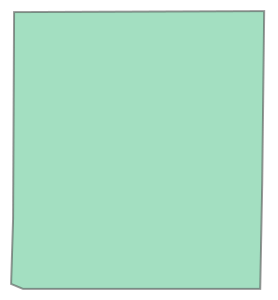

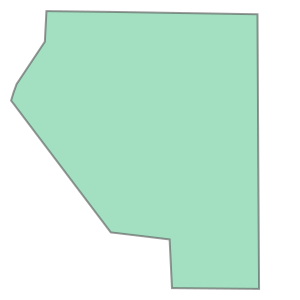

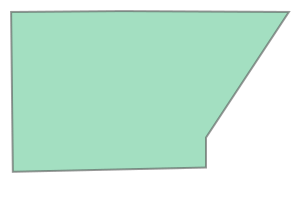

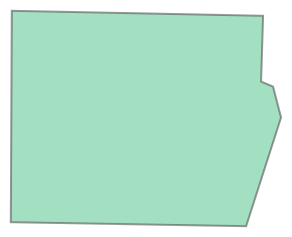

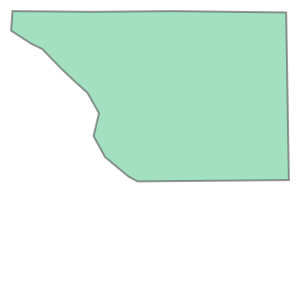

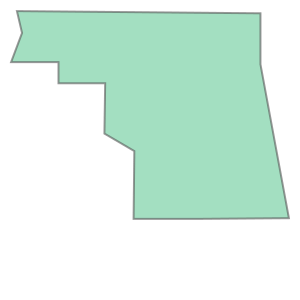

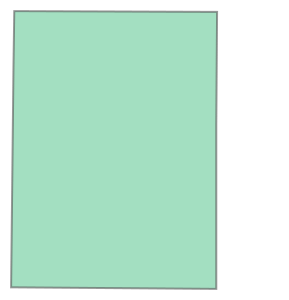

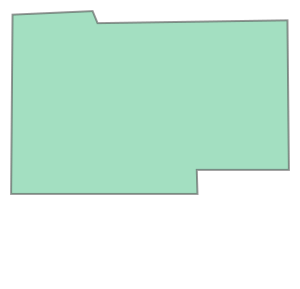

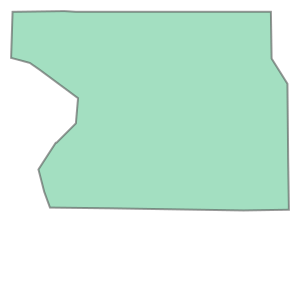

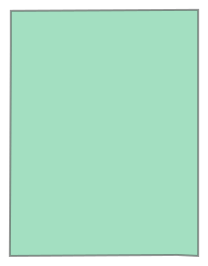

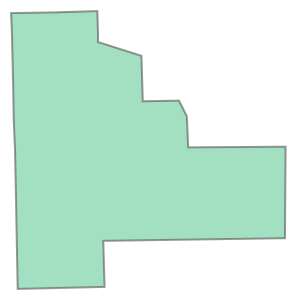

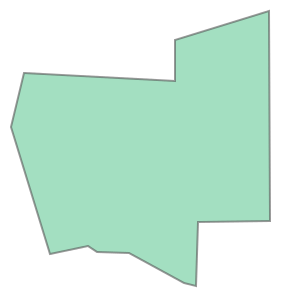

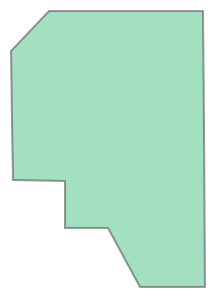

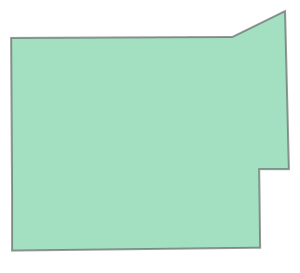

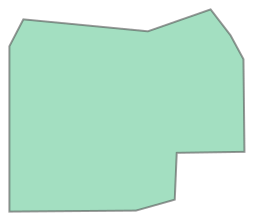

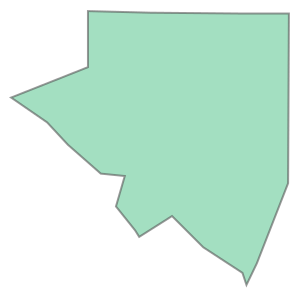

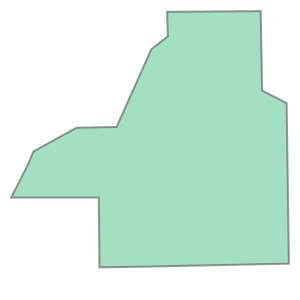

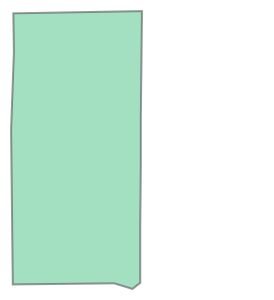

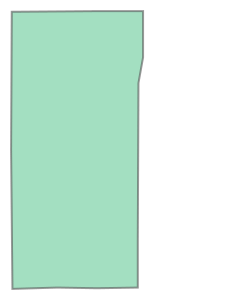

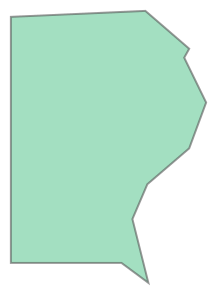

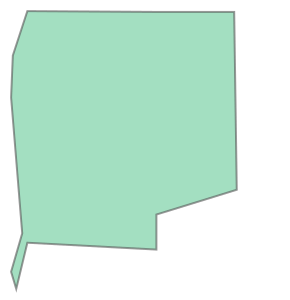

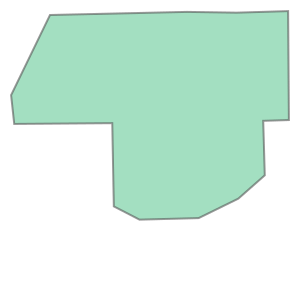

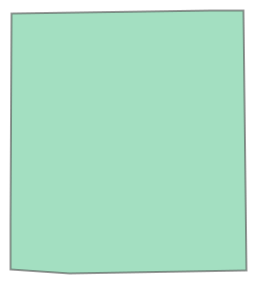

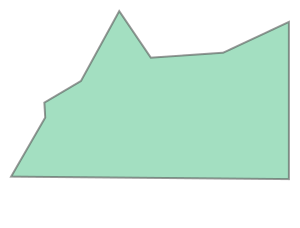

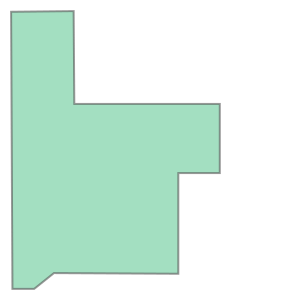

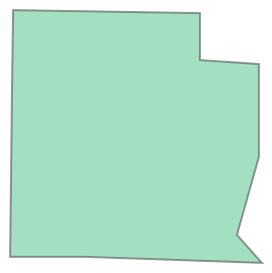

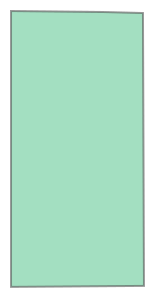

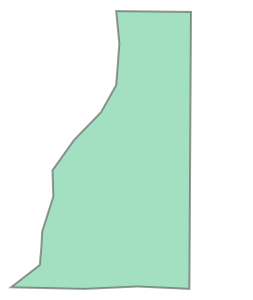

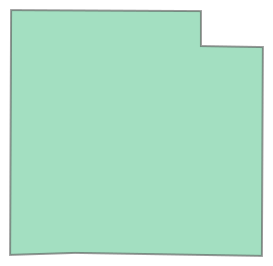

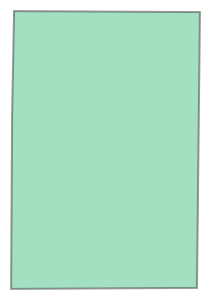

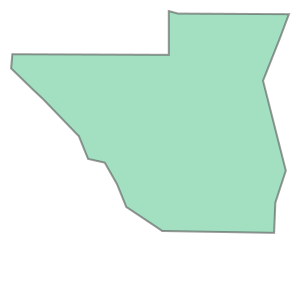

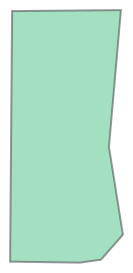

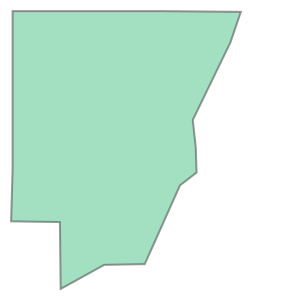

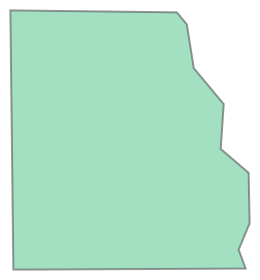

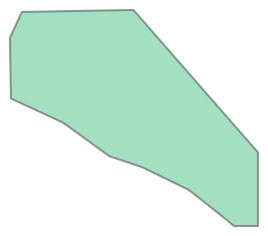

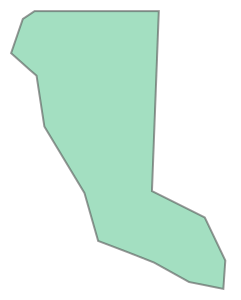

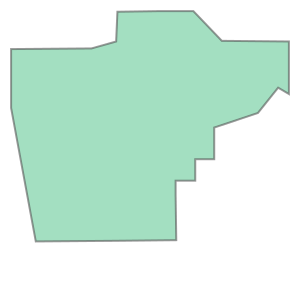

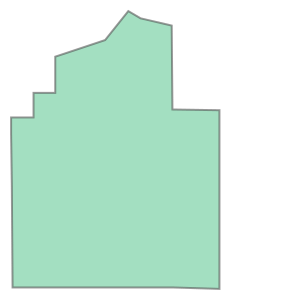

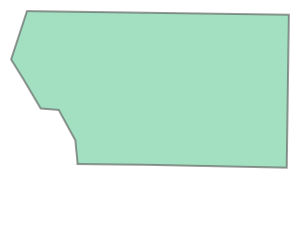

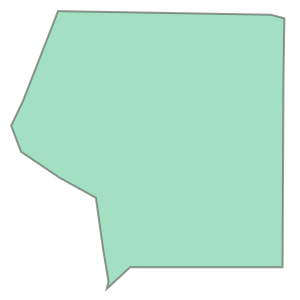

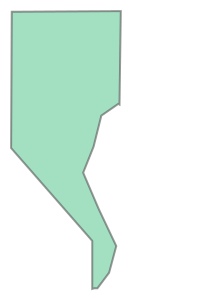

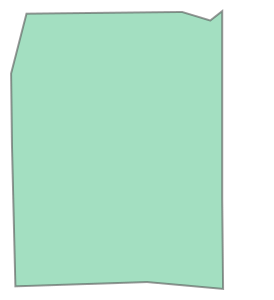

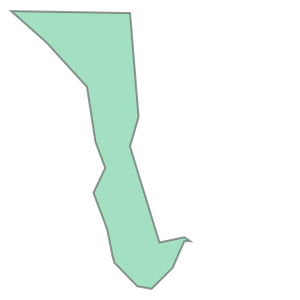

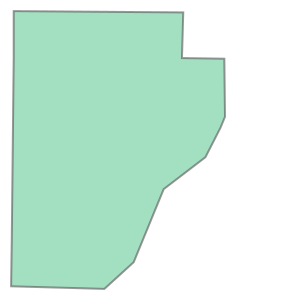

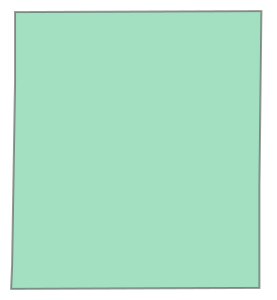

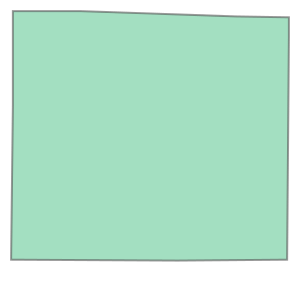

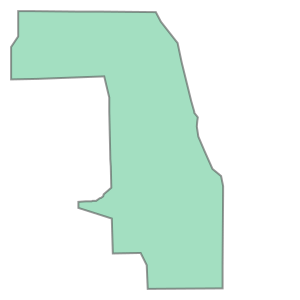

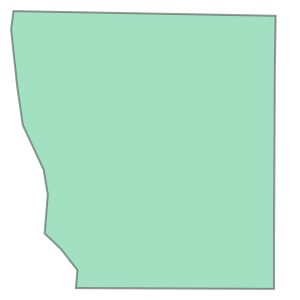

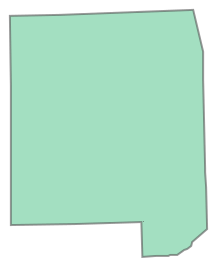

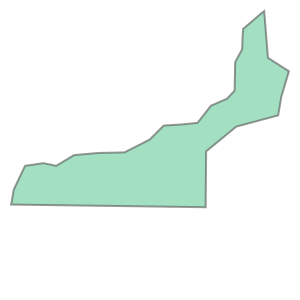

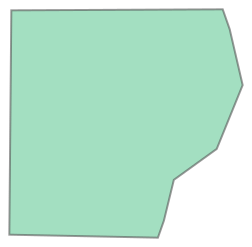

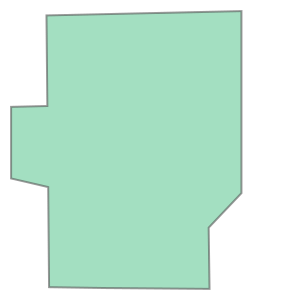

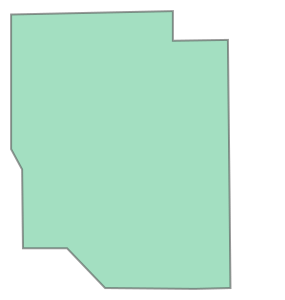

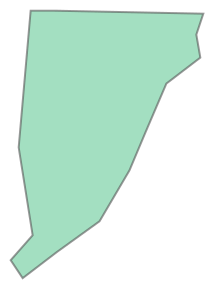

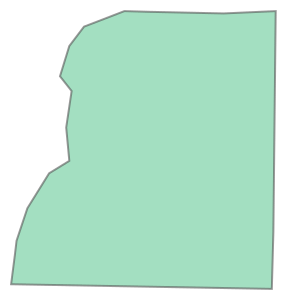

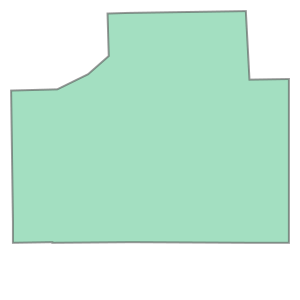

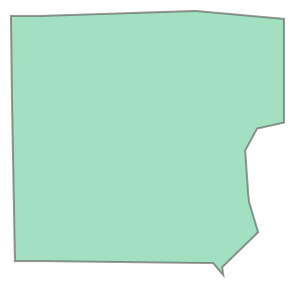

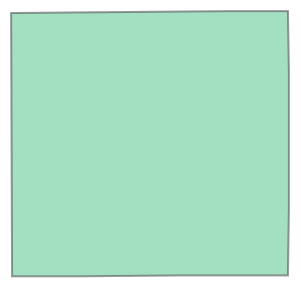

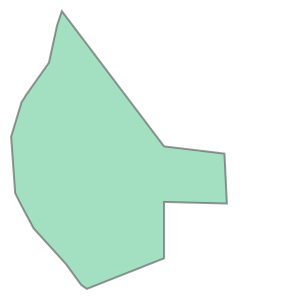

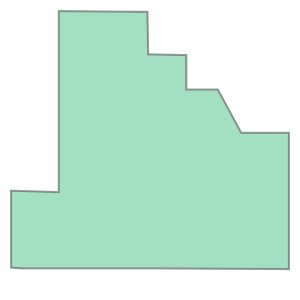

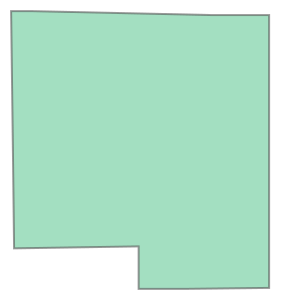

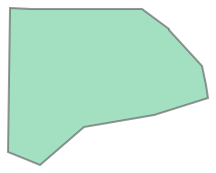

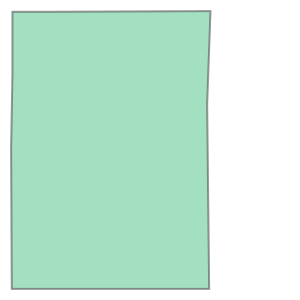

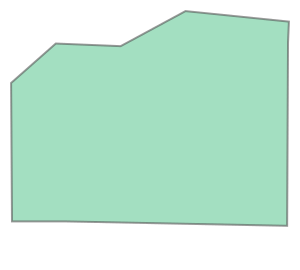

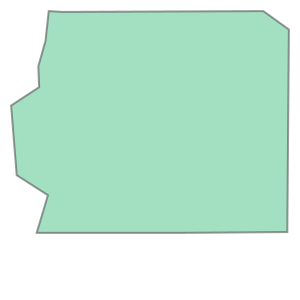

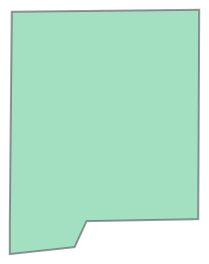

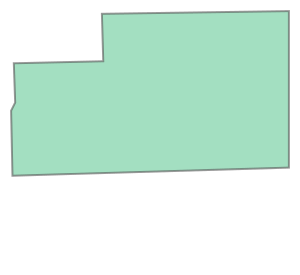

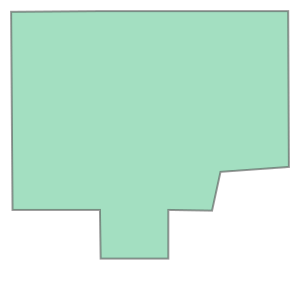

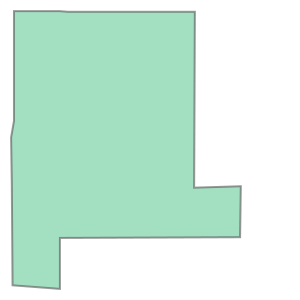

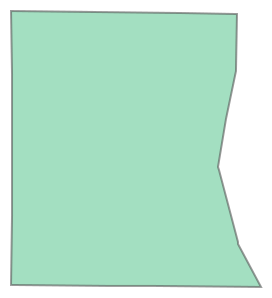

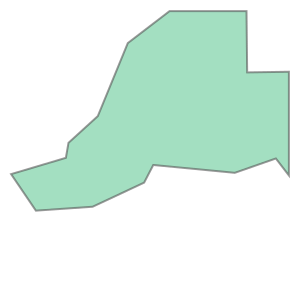

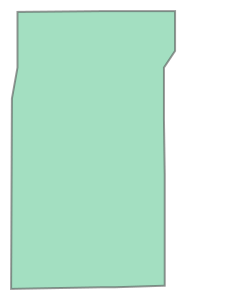

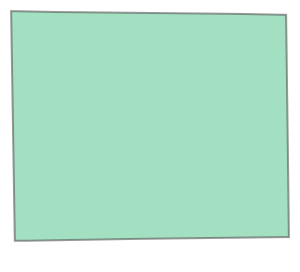

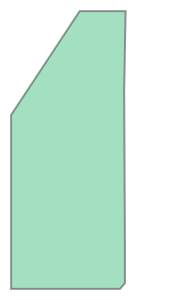

In [515]:
for x in polys:
    display(x)

In [516]:
# testing to see that these distinct and seperate polygons are not intersecting:

marshall = polys[0]
cumberland = polys[1]
marshall.intersects(cumberland)

#False -- excellent!

False

In [517]:
import math

# functions to determine points of circle

# This function gets just one pair of coordinates based on the angle theta
def get_circle_coord(theta, x_center, y_center, radius):
    x = radius * math.cos(theta) + x_center
    y = radius * math.sin(theta) + y_center
    return [int(x),int(y)]

# This function gets all the pairs of coordinates
def get_all_circle_coords(x_center, y_center, radius, n_points):
    thetas = [i/n_points * math.tau for i in range(n_points+1)]
    circle_coords = [get_circle_coord(theta, x_center, y_center, radius) for theta in thetas]
    return circle_coords

# Using the second function to generate all the pairs of coordinates.
# circle_coords = get_all_circle_coords(x_center = 5, 
#                                       y_center = 15,
#                                       radius = 2.5,
#                                       n_points = 5000)

In [518]:
# testing above functions

get_all_circle_coords(0, 0, 50, 24)
# yep, thats a circle!

[[50, 0],
 [48, 12],
 [43, 24],
 [35, 35],
 [25, 43],
 [12, 48],
 [0, 50],
 [-12, 48],
 [-24, 43],
 [-35, 35],
 [-43, 24],
 [-48, 12],
 [-50, 0],
 [-48, -12],
 [-43, -25],
 [-35, -35],
 [-25, -43],
 [-12, -48],
 [0, -50],
 [12, -48],
 [25, -43],
 [35, -35],
 [43, -25],
 [48, -12],
 [50, 0]]

In [519]:
# developing function to return intersections of circle radius
# enter radius in miles

coords = [41.015051, -89.307540]
def find_intersecting_counties(lat, long, radius):
    """Function to return intersecting counties"""
    
    refs = [36.981528, -91.511353]
    lat_ratio = ((41.148339 - 36.981528)/3344)
    long_ratio = ((-89.638487 + 91.511353)/1061)
    radius = radius/69
    radius = int(radius/lat_ratio)
    lat_pre = abs(refs[0] - lat)
    long_pre = abs(refs[1] - long)
    y_coord = int(long_pre/long_ratio)
    x_coord = int(lat_pre/lat_ratio)
    center = [y_coord, x_coord]
    coords = get_all_circle_coords(center[0], center[1], radius, 60)
    circle = Polygon(coords)
    intersectors = []
    for i, shape in enumerate(polys):
        if shape.intersects(circle):            
            intersectors.append(i)            
    return intersectors, circle

In [520]:
delta, beta = find_intersecting_counties(coords[0], coords[1], 10)

116


In [521]:
for x in delta:
    print(county_names[x])

Marshall
Putnam
LaSalle
Woodford
Peoria


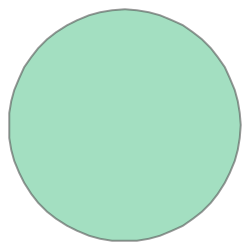

In [522]:
beta

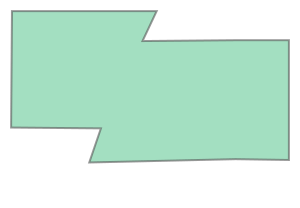

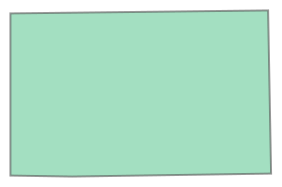

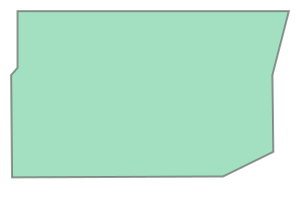

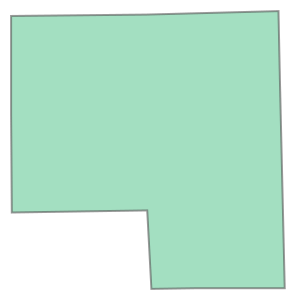

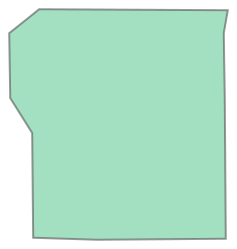

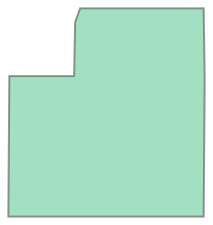

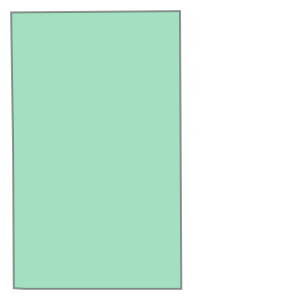

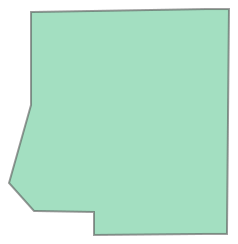

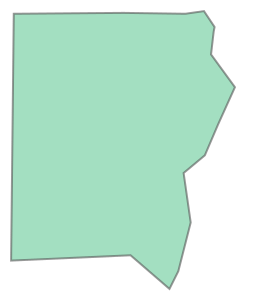

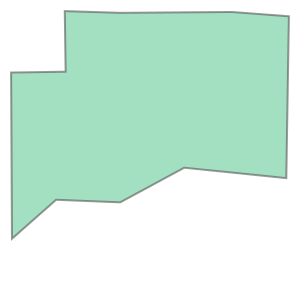

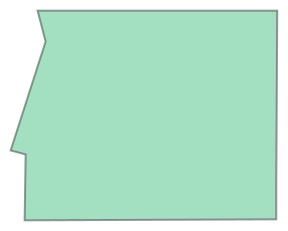

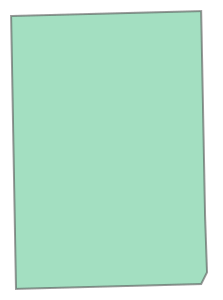

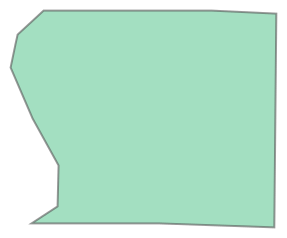

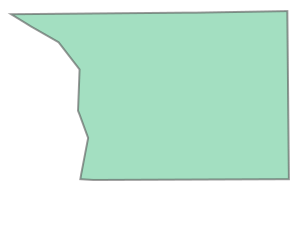

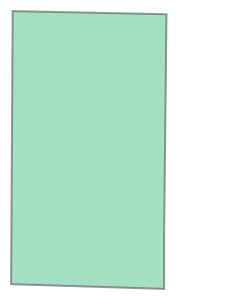

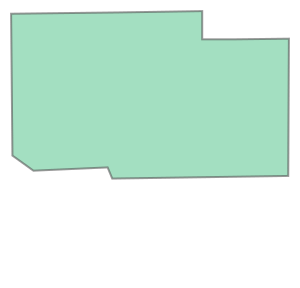

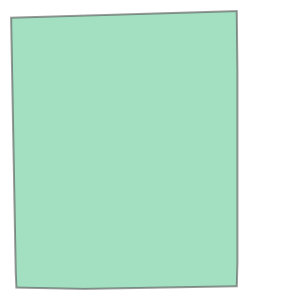

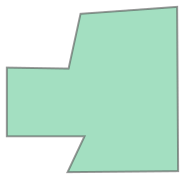

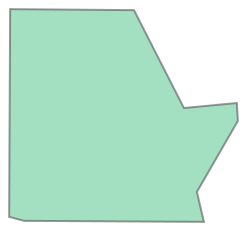

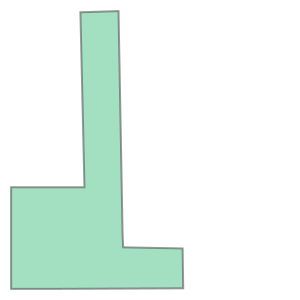

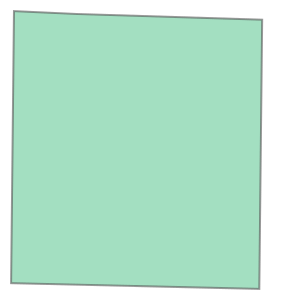

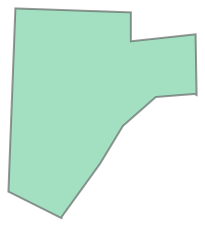

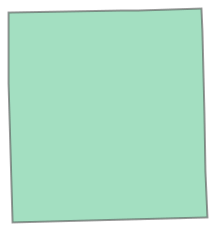

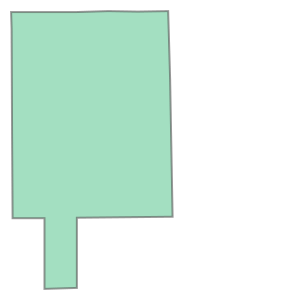

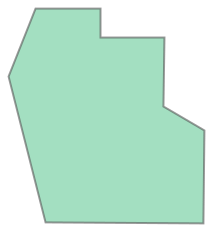

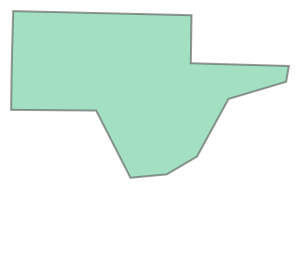

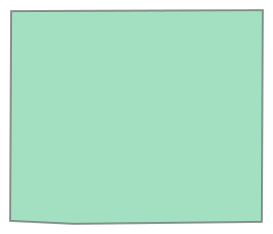

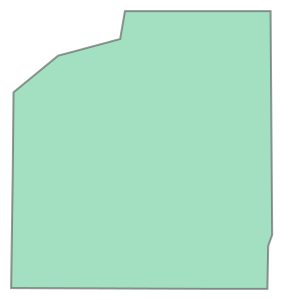

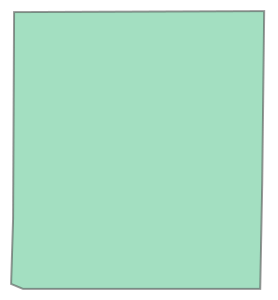

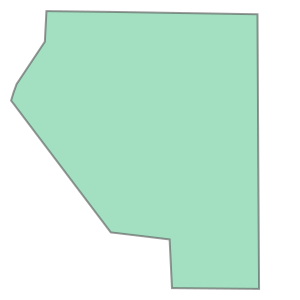

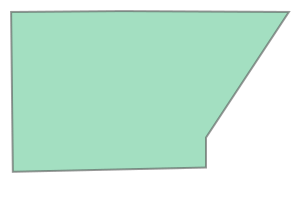

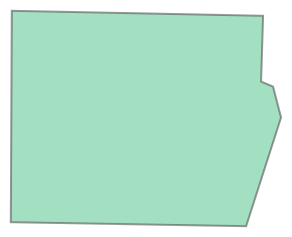

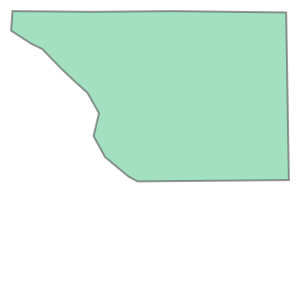

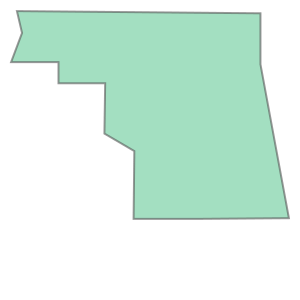

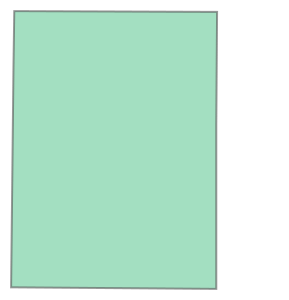

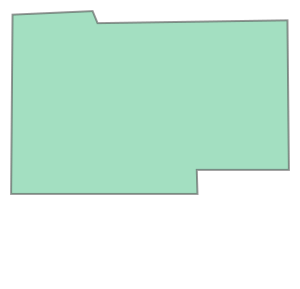

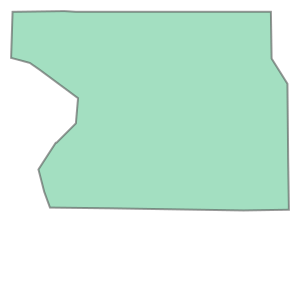

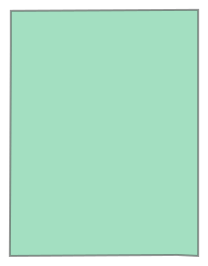

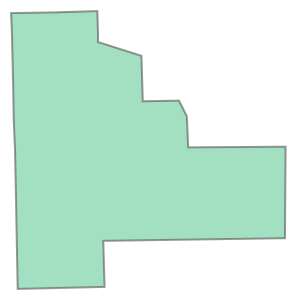

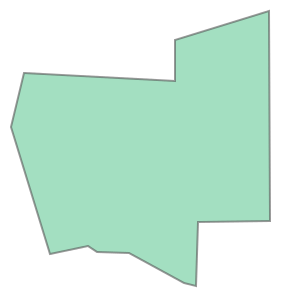

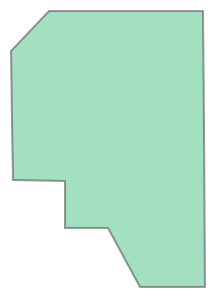

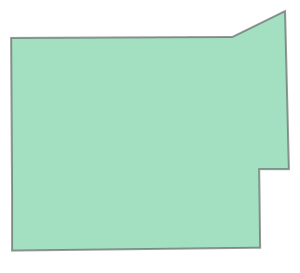

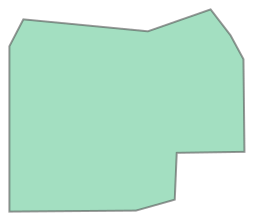

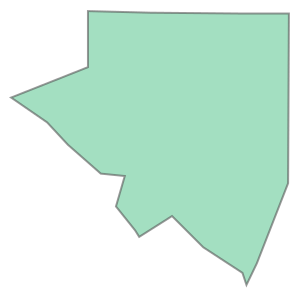

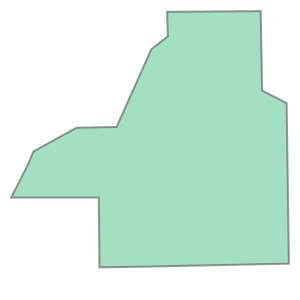

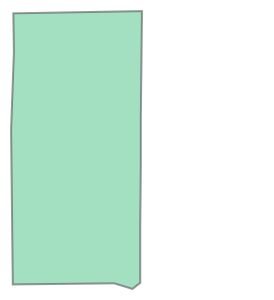

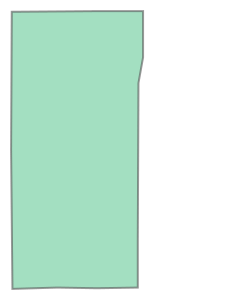

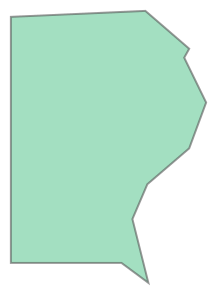

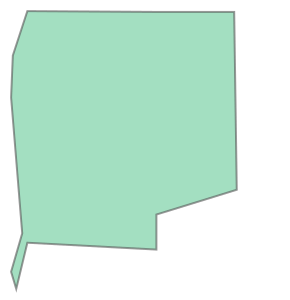

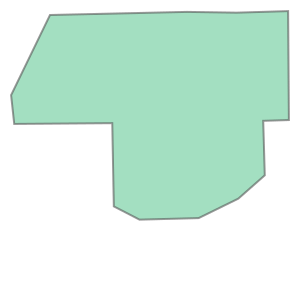

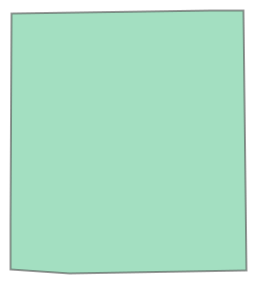

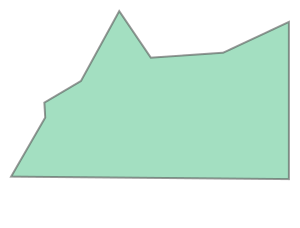

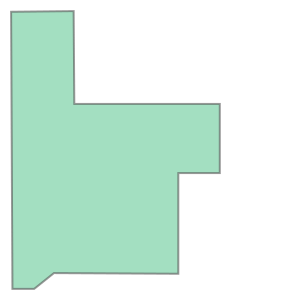

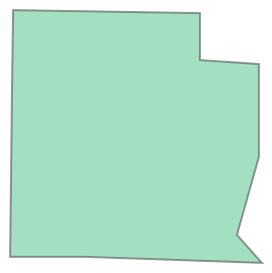

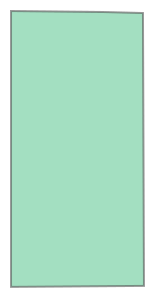

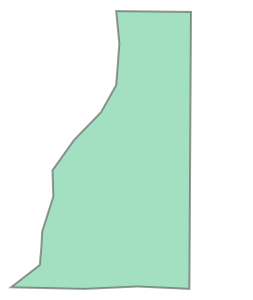

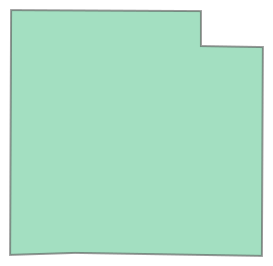

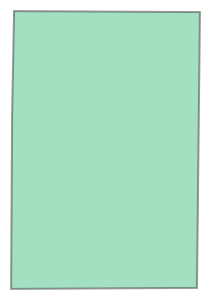

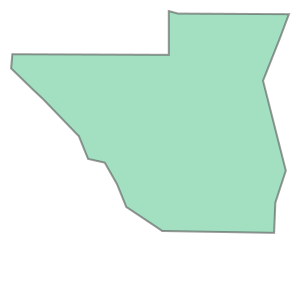

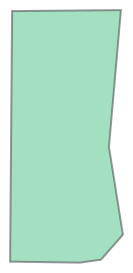

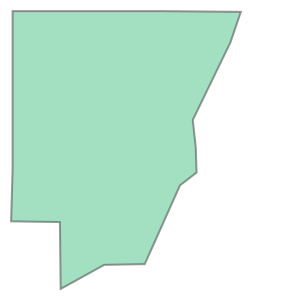

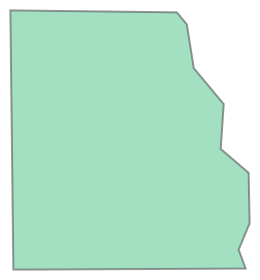

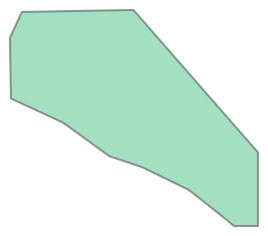

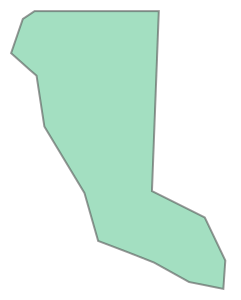

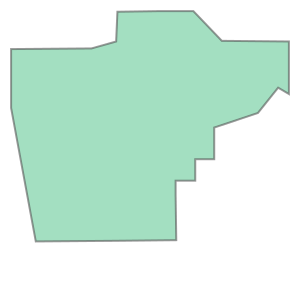

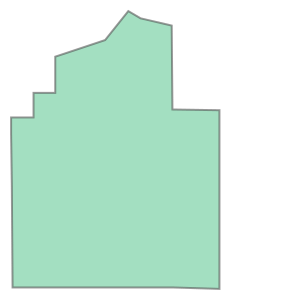

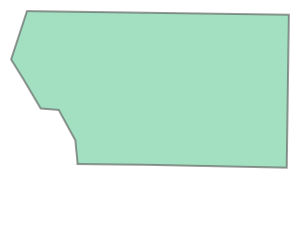

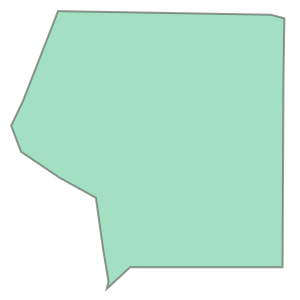

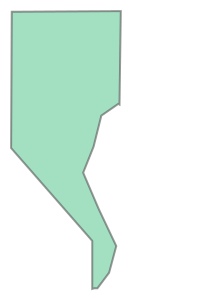

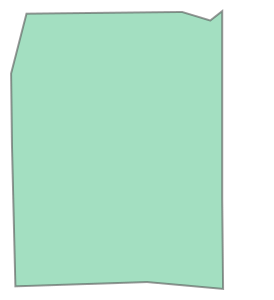

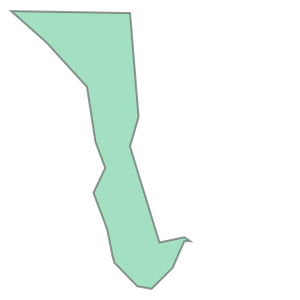

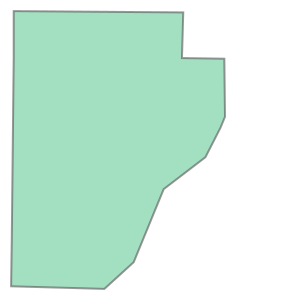

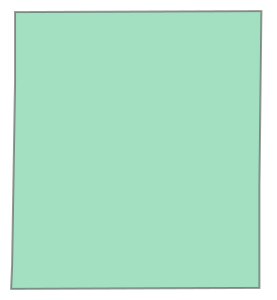

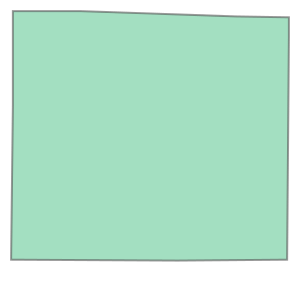

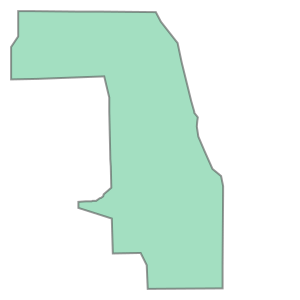

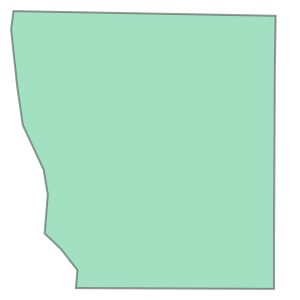

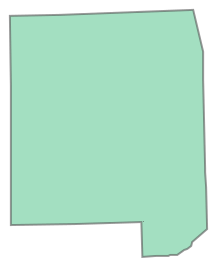

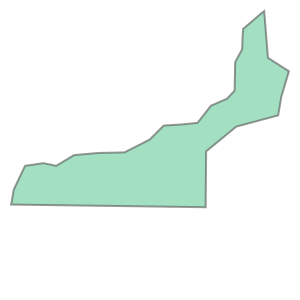

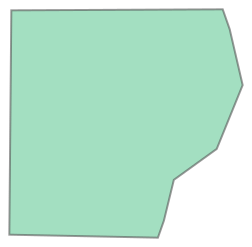

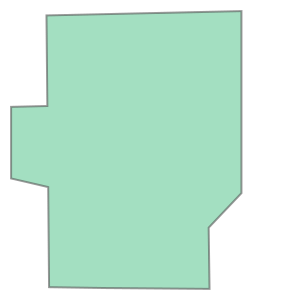

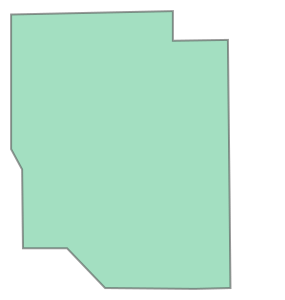

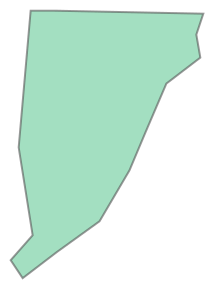

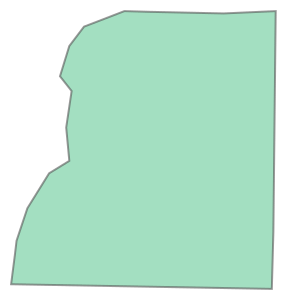

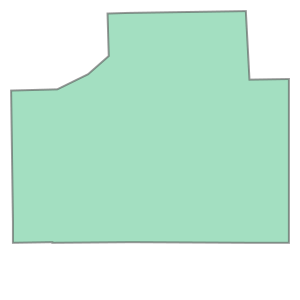

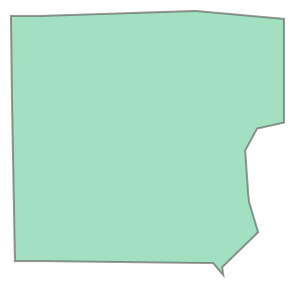

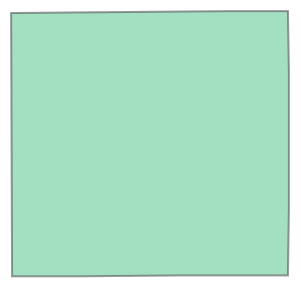

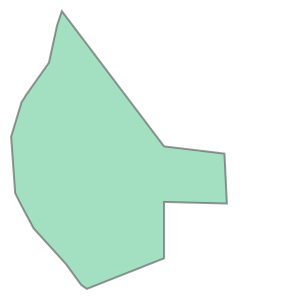

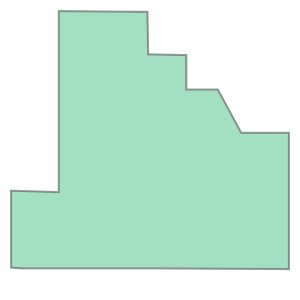

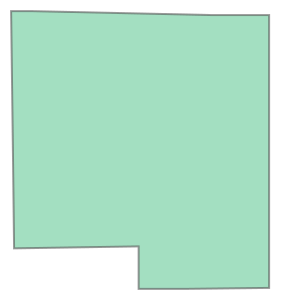

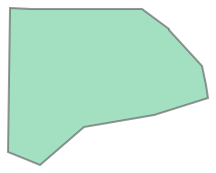

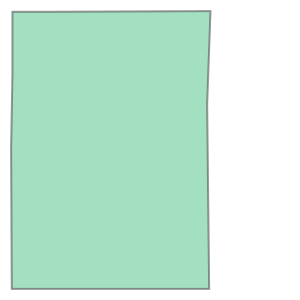

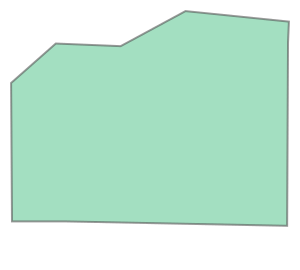

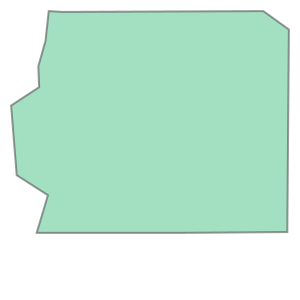

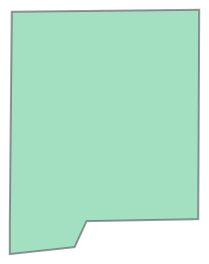

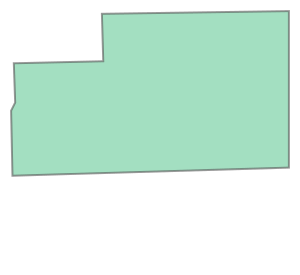

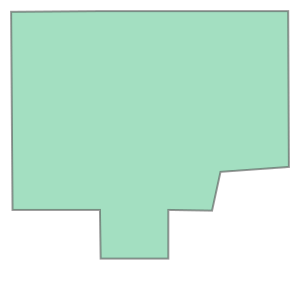

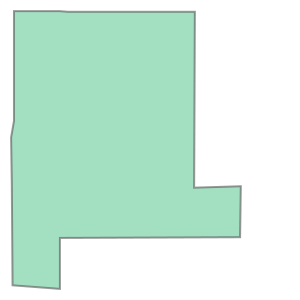

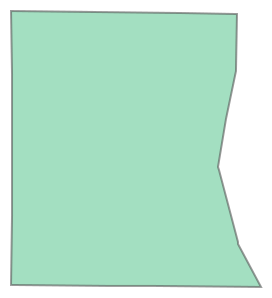

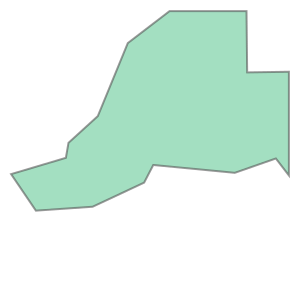

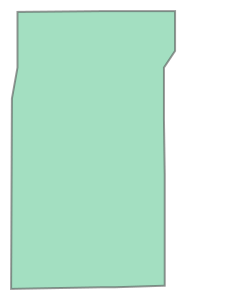

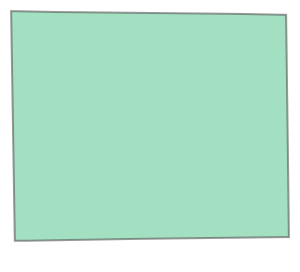

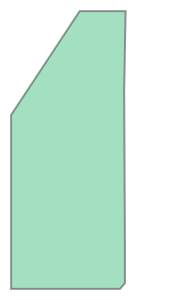

In [524]:
for x in polys:
    display(x)

In [525]:
df = pd.read_csv('<csv_here>')

In [526]:
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,139418,7316871568,https://bn.craigslist.org/ctd/d/bloomington-20...,bloomington-normal,https://bn.craigslist.org,6999,2011.0,ford,taurus,excellent,...,NaN,sedan,black,https://images.craigslist.org/00O0O_jEoiDAIzoK...,2011 Ford Taurus SEL 4dr Sedan Sedan Better ...,NaN,il,40.474352,-88.983012,2021-05-04T14:00:58-0500
1,139419,7316871387,https://bn.craigslist.org/ctd/d/bloomington-20...,bloomington-normal,https://bn.craigslist.org,11999,2014.0,nissan,pathfinder,excellent,...,NaN,SUV,white,https://images.craigslist.org/00Q0Q_c8v6AACAV6...,2014 Nissan Pathfinder Platinum 4x4 4dr SUV SU...,NaN,il,40.474352,-88.983012,2021-05-04T14:00:37-0500
2,139420,7316871164,https://bn.craigslist.org/ctd/d/bloomington-20...,bloomington-normal,https://bn.craigslist.org,14999,2016.0,honda,odyssey,excellent,...,NaN,mini-van,white,https://images.craigslist.org/00f0f_6UTvTcdeMg...,2016 Honda Odyssey SE 4dr Mini Van Mini-Van ...,NaN,il,40.474352,-88.983012,2021-05-04T14:00:18-0500
3,139421,7316676100,https://bn.craigslist.org/ctd/d/bloomington-20...,bloomington-normal,https://bn.craigslist.org,33590,2014.0,gmc,sierra 1500 crew cab slt,good,...,NaN,pickup,white,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,il,40.470000,-88.970000,2021-05-04T08:42:02-0500
4,139422,7316675898,https://bn.craigslist.org/ctd/d/bloomington-20...,bloomington-normal,https://bn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,il,40.470000,-88.970000,2021-05-04T08:41:38-0500
